### Cell 1: Imports and Device Setup

In [1]:
# Import necessary libraries
import os                             # For interacting with the operating system (e.g., file paths)
import random                         # For random operations (e.g., random sampling)
from PIL import Image                 # For image loading and processing
import numpy as np                    # For numerical operations
import matplotlib.pyplot as plt       # For plotting and visualization
import torch                          # For PyTorch tensors and model operations
import pandas as pd                   # For data in dataframe manipulation
from torch import nn, optim           # nn: Neural network layers, optim: Optimizers like SGD, Adam
from torch.nn import functional as F  # For common functions like ReLU, loss functions etc.
from torch.nn.modules.distance import PairwiseDistance  # For calculating distances (useful in Siamese networks)
from torch.utils.data import Dataset, DataLoader        # For creating datasets and loading data efficiently
from torchvision import transforms, models              # For image transformations and pretrained models
from sklearn.model_selection import train_test_split    # For splitting the datasets

# Check if GPU (CUDA) is available and select device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Cell 2: Triplet Dataset Definition

In [2]:

class TripletDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_triplets=10000, selected_classes=None):
        """
        Args:
            root_dir (str): Root directory where class folders are stored.
            transform (callable, optional): Transformations to apply to images.
            num_triplets (int): Number of triplets to generate.
            selected_classes (list, optional): List of specific class names to use.
        """
        self.root = root_dir
        self.transform = transform

        # If specific classes are given, use them; otherwise, list all directories in root_dir
        self.classes = sorted(selected_classes) if selected_classes else sorted(os.listdir(self.root))

        # Map each class name to a list of its image paths
        self.class_to_images = {
            cls: [os.path.join(self.root, cls, img)
                  for img in os.listdir(os.path.join(self.root, cls))]
            for cls in self.classes
        }

        # Pre-generate a list of triplets (anchor, positive, negative)
        self.triplets = self._generate_triplets(num_triplets)

    def _generate_triplets(self, num_triplets):
        """
        Generates a list of triplet tuples (anchor, positive, negative).
        """
        triplets = []
        for _ in range(num_triplets):
            pos_cls = random.choice(self.classes)  # Select a positive class
            neg_cls = random.choice(self.classes)  # Select a negative class

            # Make sure positive class has at least two images
            while len(self.class_to_images[pos_cls]) < 2:
                pos_cls = random.choice(self.classes)

            # Ensure negative class is different and has at least one image
            while neg_cls == pos_cls or len(self.class_to_images[neg_cls]) < 1:
                neg_cls = random.choice(self.classes)

            # Randomly pick two different images from positive class
            anchor_path, positive_path = random.sample(self.class_to_images[pos_cls], 2)
            # Randomly pick one image from negative class
            negative_path = random.choice(self.class_to_images[neg_cls])

            triplets.append((anchor_path, positive_path, negative_path))

        return triplets

    def __len__(self):
        """
        Returns the number of triplets available.
        """
        return len(self.triplets)

    def __getitem__(self, idx):
        """
        Fetches the triplet (anchor, positive, negative) at the given index.
        """
        a_path, p_path, n_path = self.triplets[idx]

        # Load images and convert to RGB (ensures consistency)
        anchor = Image.open(a_path).convert('RGB')
        positive = Image.open(p_path).convert('RGB')
        negative = Image.open(n_path).convert('RGB')

        # Apply transformations if provided (e.g., resizing, normalization)
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative

### Cell 3: Data Transforms, Splits & Loaders

In [3]:
# 1) Set the dataset path and define image preprocessing steps
DATA_PATH = "lfw"
transform = transforms.Compose([
    transforms.Resize((256, 256)),              # Resize images to 256x256
    transforms.CenterCrop(224),                 # Crop the center 224x224 patch (standard size for ResNet)
    transforms.ToTensor(),                      # Convert PIL images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet statistics
                         std=[0.229, 0.224, 0.225]),
])

# Ensure the dataset directory exists
if not os.path.isdir(DATA_PATH):
    raise FileNotFoundError(f"Data directory '{DATA_PATH}' not found. Please update DATA_PATH.")

# 2) Get all class names (folders) and split into train/validation/test sets
all_classes = sorted(os.listdir(DATA_PATH))  # List all class folders
train_classes, temp = train_test_split(all_classes, test_size=0.3, random_state=42)  # 70% for training
val_classes, test_classes = train_test_split(temp, test_size=0.5, random_state=42)   # 15% validation, 15% test

# 3) Create three TripletDataset objects for train/val/test
train_ds = TripletDataset(DATA_PATH, transform, num_triplets=5000, selected_classes=train_classes)
val_ds   = TripletDataset(DATA_PATH, transform, num_triplets=1000, selected_classes=val_classes)
test_ds  = TripletDataset(DATA_PATH, transform, num_triplets=1000, selected_classes=test_classes)

# Create corresponding DataLoaders for batching and shuffling
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=4)  # Shuffle for training
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=4) # No shuffle for validation
test_loader  = DataLoader(test_ds,  batch_size=8, shuffle=False, num_workers=4) # No shuffle for testing

# Print a summary of how many classes are in each split
print(f"Train/{len(train_classes)}  Val/{len(val_classes)}  Test/{len(test_classes)} classes")

Train/4024  Val/862  Test/863 classes


### Cell 4: Siamese Network and Triplet Loss

In [4]:
# Define the Siamese Network for embedding generation
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        # Load a pre-trained ResNet18 model
        backbone = models.resnet18(pretrained=True)
        modules = list(backbone.children())[:-1]  # Remove the final classification layer
        self.feature_extractor = nn.Sequential(*modules)  # Use everything except the final FC layer

        # Add a new fully connected layer to project features into a lower-dimensional embedding space
        self.fc = nn.Linear(backbone.fc.in_features, embedding_dim)

    def forward_once(self, x):
        # Pass input through the feature extractor
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)             # Project to embedding_dim
        return F.normalize(x, p=2, dim=1)  # Normalize embeddings to have unit L2 norm

    def forward(self, a, p, n):
        # Forward pass for a triplet: anchor (a), positive (p), negative (n)
        return self.forward_once(a), self.forward_once(p), self.forward_once(n)

# Define the Triplet Loss function
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin  # Margin that enforces distance between positive and negative pairs
        self.pdist = PairwiseDistance(p=2)  # L2 distance

    def forward(self, a, p, n):
        pos_dist = self.pdist(a, p)  # Distance between anchor and positive
        neg_dist = self.pdist(a, n)  # Distance between anchor and negative

        # Compute the triplet loss
        loss = F.relu(pos_dist - neg_dist + self.margin)

        # Return the mean loss, along with distances (useful for monitoring)
        return loss.mean(), pos_dist, neg_dist

# class SiameseNetwork(nn.Module):
#     def __init__(self, embedding_dim=128):
#         super().__init__()
#         # Custom convolutional backbone (compatible input/output shapes)
#         self.cnn = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 224×224×3 → 224×224×32
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),                             # → 112×112×32
#             nn.Conv2d(32, 64, kernel_size=3, padding=1), # → 112×112×64
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),                             # → 56×56×64
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),# → 56×56×128
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),                             # → 28×28×128
#             nn.Conv2d(128, 256, kernel_size=3, padding=1),# → 28×28×256
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),                             # → 14×14×256
#             nn.Conv2d(256, 512, kernel_size=3, padding=1),# → 14×14×512
#             nn.ReLU(inplace=True),
#             nn.AdaptiveAvgPool2d((1,1))                  # → 1×1×512
#         )
#         # Final embedding layer
#         self.fc = nn.Sequential(
#             nn.Linear(512, embedding_dim),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm1d(embedding_dim)
#         )

#     def forward_once(self, x):
#         x = self.cnn(x)
#         x = x.view(x.size(0), -1)   # flatten to (batch_size, 512)
#         x = self.fc(x)              # → (batch_size, embedding_dim)
#         return F.normalize(x, p=2, dim=1)

#     def forward(self, anchor, positive, negative):
#         return (self.forward_once(anchor),
#                 self.forward_once(positive),
#                 self.forward_once(negative))


# class TripletLoss(nn.Module):
#     def __init__(self, margin=1.0):
#         super().__init__()
#         self.margin = margin
#         self.pdist = PairwiseDistance(p=2)

#     def forward(self, anchor, positive, negative):
#         pos_dist = self.pdist(anchor, positive)  # ‖f(a)–f(p)‖₂
#         neg_dist = self.pdist(anchor, negative)  # ‖f(a)–f(n)‖₂
#         loss = F.relu(pos_dist - neg_dist + self.margin)
#         return loss.mean(), pos_dist, neg_dist

### Cell 5: Training Loop + Validation

In [5]:
# Initialize the model, loss function, and optimizer
model = SiameseNetwork().to(device)  # Move the model to GPU if available
criterion = TripletLoss(margin=1.0)  # Use triplet loss with a margin of 1.0
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adam optimizer with a learning rate of 1e-4

num_epochs = 20  # Total number of training epochs
logs = {'epoch': [], 'phase': [], 'batch': [], 'loss': [], 'accuracy': []}  # Logs to track training progress

# Training loop across epochs
for epoch in range(num_epochs):
    for phase in ['train', 'val']:  # Iterate over training and validation phases
        loader = train_loader if phase == 'train' else val_loader  # Choose the data loader based on the phase
        model.train() if phase == 'train' else model.eval()  # Set model to training mode or evaluation mode

        running_loss = 0.0  # To accumulate the loss over batches
        correct = 0  # Count of correctly classified triplets
        total = 0  # Total number of triplets processed

        # Iterate through batches in the data loader
        for batch_idx, (a, p, n) in enumerate(loader, 1):
            # Move the input triplets (anchor, positive, negative) to the GPU
            a, p, n = a.to(device), p.to(device), n.to(device)

            # Zero the gradients for the optimizer before backward pass
            optimizer.zero_grad()

            # Only compute gradients for training phase
            with torch.set_grad_enabled(phase == 'train'):
                # Forward pass through the model to get the embeddings for anchor, positive, and negative images
                emb_a, emb_p, emb_n = model(a, p, n)

                # Compute triplet loss
                loss, pos_d, neg_d = criterion(emb_a, emb_p, emb_n)

                # Backpropagate and optimize if we are in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Compute batch accuracy (number of correctly classified triplets)
            batch_correct = (pos_d < neg_d).sum().item()  # True if positive pair distance < negative pair distance
            batch_total = pos_d.size(0)  # Total number of triplets in the batch
            acc = batch_correct / batch_total  # Accuracy of the batch

            # Accumulate loss and accuracy over the batch
            running_loss += loss.item()
            correct += batch_correct
            total += batch_total

            # Log metrics for later analysis or plotting
            logs['epoch'].append(epoch + 1)
            logs['phase'].append(phase)
            logs['batch'].append(batch_idx)
            logs['loss'].append(loss.item())
            logs['accuracy'].append(acc)

            # Print batch-level info for training phase
            if phase == 'train' and batch_idx % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] Train Batch [{batch_idx}]  Loss {loss:.4f} Acc {acc:.4f}")

        # Calculate epoch loss and accuracy
        epoch_loss = running_loss / len(loader)  # Average loss for the epoch
        epoch_acc = correct / total  # Overall accuracy for the epoch

        # Print epoch-level info
        print(f"--> Epoch {epoch+1} {phase.upper()}  Loss {epoch_loss:.4f}  Acc {epoch_acc:.4f}")

/home/cognidev-technologies/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cognidev-technologies/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/cognidev-technologies/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [02:38<00:00, 296kB/s]


Epoch [1/20] Train Batch [100]  Loss 0.4933 Acc 0.8750
Epoch [1/20] Train Batch [200]  Loss 0.1637 Acc 1.0000
Epoch [1/20] Train Batch [300]  Loss 0.3298 Acc 0.8750
Epoch [1/20] Train Batch [400]  Loss 0.1036 Acc 1.0000
Epoch [1/20] Train Batch [500]  Loss 0.0671 Acc 1.0000
Epoch [1/20] Train Batch [600]  Loss 0.1665 Acc 1.0000
--> Epoch 1 TRAIN  Loss 0.3781  Acc 0.9068
--> Epoch 1 VAL  Loss 0.3417  Acc 0.9030
Epoch [2/20] Train Batch [100]  Loss 0.2983 Acc 0.8750
Epoch [2/20] Train Batch [200]  Loss 0.0509 Acc 1.0000
Epoch [2/20] Train Batch [300]  Loss 0.1941 Acc 1.0000
Epoch [2/20] Train Batch [400]  Loss 0.1628 Acc 1.0000
Epoch [2/20] Train Batch [500]  Loss 0.3053 Acc 0.8750
Epoch [2/20] Train Batch [600]  Loss 0.0207 Acc 1.0000
--> Epoch 2 TRAIN  Loss 0.2149  Acc 0.9648
--> Epoch 2 VAL  Loss 0.3113  Acc 0.9320
Epoch [3/20] Train Batch [100]  Loss 0.1099 Acc 1.0000
Epoch [3/20] Train Batch [200]  Loss 0.1853 Acc 1.0000
Epoch [3/20] Train Batch [300]  Loss 0.2600 Acc 1.0000
Epoch [

KeyboardInterrupt: 

### Cell 6: Testing Loop + Model's Accuracy

In [6]:
# Switch model to evaluation mode (disables dropout and batch norm behavior)
model.eval()

# Initialize variables to track loss and accuracy during the test phase
test_loss = 0.0  # Total loss for all batches
test_correct = 0  # Number of correctly classified triplets
test_total = 0  # Total number of triplets processed

# Disable gradient calculation for the test phase (inference only)
with torch.no_grad():
    # Iterate through test batches
    for a, p, n in test_loader:
        # Move the input triplets (anchor, positive, negative) to the GPU
        a, p, n = a.to(device), p.to(device), n.to(device)

        # Forward pass: Get the embeddings for anchor, positive, and negative images
        emb_a, emb_p, emb_n = model(a, p, n)

        # Compute triplet loss
        loss, pos_d, neg_d = criterion(emb_a, emb_p, emb_n)

        # Accumulate loss over all batches
        test_loss += loss.item()

        # Count the correctly classified triplets (positive distance < negative distance)
        test_correct += (pos_d < neg_d).sum().item()
        test_total += pos_d.size(0)  # Number of triplets in the current batch

# Calculate average test loss and accuracy
test_loss /= len(test_loader)  # Average loss over all test batches
test_acc = test_correct / test_total  # Overall accuracy for the test set

# Print final test results
print(f"*** TEST RESULTS ***  Loss {test_loss:.4f}  Acc {test_acc:.4f}")

*** TEST RESULTS ***  Loss 0.2917  Acc 0.9270


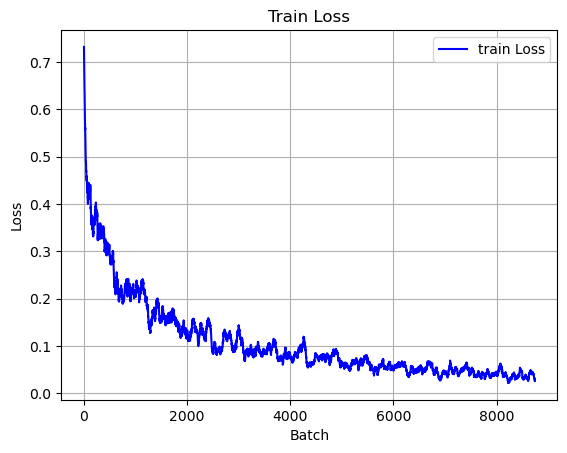

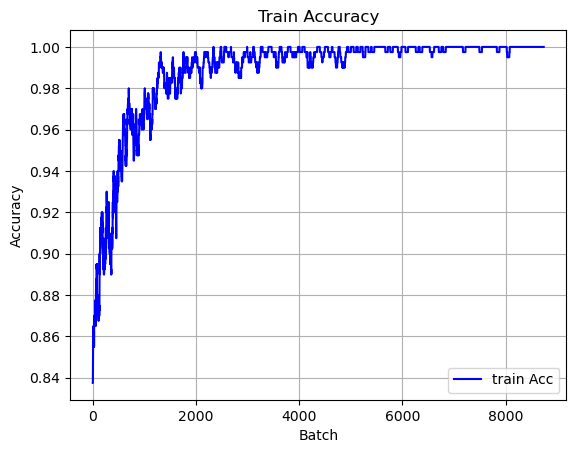

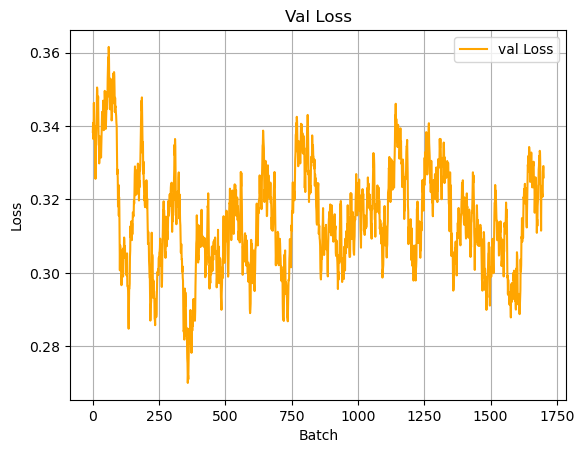

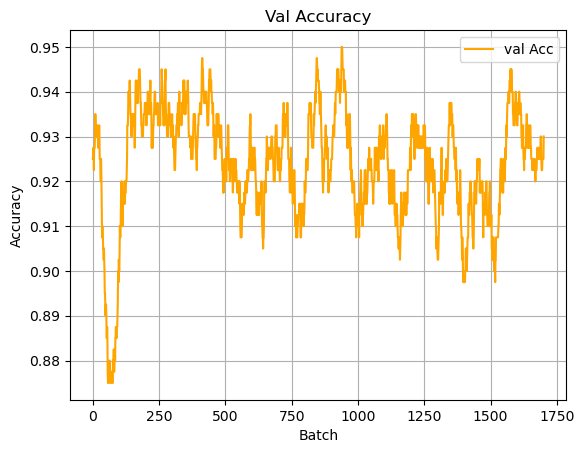

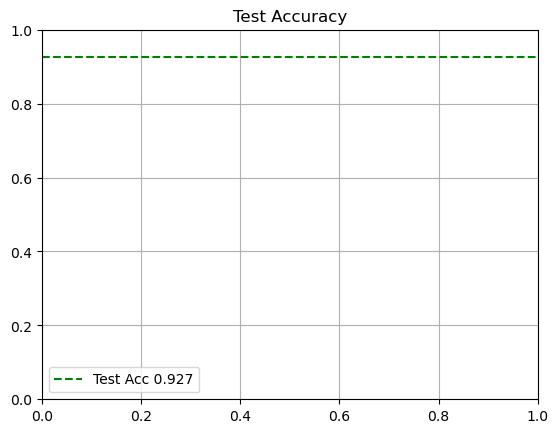

In [8]:
# Importing pandas for data handling (DataFrame)

# Convert logs (which is a dictionary) into a DataFrame for easier analysis and plotting
df = pd.DataFrame(logs)

# Function for calculating a moving average to smooth the loss and accuracy curves
# This helps to remove noise in the training/validation metrics plots
def smooth(vals, w=50):
    return np.convolve(vals, np.ones(w)/w, mode='valid')

# Loop through the phases (train and val) to plot the respective metrics
for phase, color in zip(['train', 'val'], ['blue', 'orange']):
    # Filter the logs for the current phase (train or val)
    phase_df = df[df.phase == phase]

    # Plot the smoothed loss for the current phase
    plt.figure()
    plt.plot(smooth(phase_df.loss), label=f'{phase} Loss', color=color)
    plt.xlabel('Batch')  # X-axis label (Batch number)
    plt.ylabel('Loss')  # Y-axis label (Loss value)
    plt.legend()  # Add legend
    plt.title(f'{phase.capitalize()} Loss')  # Title with the phase name
    plt.grid()  # Display grid for easier readability

    # Plot the smoothed accuracy for the current phase
    plt.figure()
    plt.plot(smooth(phase_df.accuracy), label=f'{phase} Acc', color=color)
    plt.xlabel('Batch')  # X-axis label (Batch number)
    plt.ylabel('Accuracy')  # Y-axis label (Accuracy value)
    plt.legend()  # Add legend
    plt.title(f'{phase.capitalize()} Accuracy')  # Title with the phase name
    plt.grid()  # Display grid for easier readability

# Test is a single point, so plot it as a horizontal line
plt.figure()
plt.axhline(test_acc, color='green', linestyle='--', label=f'Test Acc {test_acc:.3f}')
plt.title('Test Accuracy')  # Title of the test accuracy plot
plt.legend()  # Add legend
plt.grid()  # Display grid for easier readability

In [9]:
### Cell 8: Save and Load Model
save_path = "triplet_siamese.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

loaded_model = SiameseNetwork().to(device)
loaded_model.load_state_dict(torch.load(save_path, map_location=device))
loaded_model.eval()
print("Model loaded and set to eval mode.")

Model saved to triplet_siamese.pth
Model loaded and set to eval mode.


In [10]:
loaded_model

SiameseNetwork(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru